In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/handwritten-az/handwritten_data_785.csv


# GPU

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [3]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Load the dataset
file_path = '/kaggle/input/handwritten-az/handwritten_data_785.csv'
data = pd.read_csv(file_path)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.562,0.563,0.564,0.565,0.566,0.567,0.568,0.569,0.570,0.571
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = data.iloc[:, 1:].values # Pixels
y = data.iloc[:, 0].values  # Labels (A-Z, 0-25)

# Normalize
X = X / 255.0
X = X.reshape(-1, 28, 28).astype('float32')

# First split to separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split to divide the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [6]:
# Create a custom dataset class
class HandwrittenAlphabetsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
# Create datasets
train_dataset = HandwrittenAlphabetsDataset(X_train, y_train, transform=transform)
val_dataset = HandwrittenAlphabetsDataset(X_val, y_val, transform=transform)
test_dataset = HandwrittenAlphabetsDataset(X_test, y_test, transform=transform)

In [9]:
# Check the shape of a sample from the dataset
train_dataset[0][0].shape, train_dataset[0][1] , len(train_dataset)

(torch.Size([1, 28, 28]), 10, 223221)

In [10]:
from torch.utils.data import DataLoader

batch_size = 64  # You can adjust the batch size according to your system's capability

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
import torchvision.models as models
import torch.nn as nn

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer for 26 classes (A-Z)
model.fc = nn.Linear(model.fc.in_features, 26)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.9MB/s]


In [12]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import torch.optim as optim

criterions = [nn.CrossEntropyLoss()]
optimizers = [optim.Adam(model.parameters(), lr=0.001), optim.SGD(model.parameters(), lr=0.001, momentum=0.9)]

In [14]:
from tqdm import tqdm

# 각 조합에 대한 결과 저장

results = {}
best_val_loss = 9999999
epochs = 10

for criterion in criterions:
    for optimizer in optimizers:
        # 손실 저장을 위한 리스트 초기화
        train_losses, val_losses = [], []

        for epoch in range(epochs):
            # Training
            model.train()
            total_train_loss = 0
            for images, labels in tqdm(train_loader):
                images, labels = images.to(device), labels.to(device)
                images = images.float()

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model.state_dict()
                print(f"New best model found!")
                print(f"Criterion: {criterion.__class__.__name__}")
                print(f"Optimizer: {optimizer.__class__.__name__}")
                print(f"Epoch: {epoch + 1}")
                print(f"Validation Loss: {avg_val_loss}")

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

        combination_name = f'{criterion.__class__.__name__}_{optimizer.__class__.__name__}'
        results[combination_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses
        }

100%|██████████| 3488/3488 [11:02<00:00,  5.26it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 1
Validation Loss: 0.1022629012694656
Epoch 1, Train Loss: 0.18906467808426547, Validation Loss: 0.1022629012694656


100%|██████████| 3488/3488 [11:07<00:00,  5.23it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 2
Validation Loss: 0.08579871608508928
Epoch 2, Train Loss: 0.09694284207243398, Validation Loss: 0.08579871608508928


100%|██████████| 3488/3488 [11:07<00:00,  5.22it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 3
Validation Loss: 0.06533128001436075
Epoch 3, Train Loss: 0.0741440954909795, Validation Loss: 0.06533128001436075


100%|██████████| 3488/3488 [11:13<00:00,  5.18it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 4
Validation Loss: 0.05835845490289141
Epoch 4, Train Loss: 0.06038112278299504, Validation Loss: 0.05835845490289141


100%|██████████| 3488/3488 [11:18<00:00,  5.14it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 5
Validation Loss: 0.0540656983858993
Epoch 5, Train Loss: 0.056337065331542674, Validation Loss: 0.0540656983858993


100%|██████████| 3488/3488 [11:37<00:00,  5.00it/s]


Epoch 6, Train Loss: 0.04216757543992671, Validation Loss: 0.05799350394498595


100%|██████████| 3488/3488 [11:50<00:00,  4.91it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 7
Validation Loss: 0.049579522273011156
Epoch 7, Train Loss: 0.04526376613109587, Validation Loss: 0.049579522273011156


100%|██████████| 3488/3488 [11:56<00:00,  4.87it/s]


Epoch 8, Train Loss: 0.03873168201731259, Validation Loss: 0.0498558482447143


100%|██████████| 3488/3488 [11:59<00:00,  4.84it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 9
Validation Loss: 0.04384574357107696
Epoch 9, Train Loss: 0.031447674423336576, Validation Loss: 0.04384574357107696


100%|██████████| 3488/3488 [12:24<00:00,  4.69it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: Adam
Epoch: 10
Validation Loss: 0.04178381038655812
Epoch 10, Train Loss: 0.03346146137193183, Validation Loss: 0.04178381038655812


100%|██████████| 3488/3488 [09:00<00:00,  6.46it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: SGD
Epoch: 1
Validation Loss: 0.0380774249008351
Epoch 1, Train Loss: 0.018062693823869953, Validation Loss: 0.0380774249008351


100%|██████████| 3488/3488 [09:06<00:00,  6.38it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: SGD
Epoch: 2
Validation Loss: 0.03730384985066375
Epoch 2, Train Loss: 0.016428648018526632, Validation Loss: 0.03730384985066375


100%|██████████| 3488/3488 [09:17<00:00,  6.25it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: SGD
Epoch: 3
Validation Loss: 0.03672562971758105
Epoch 3, Train Loss: 0.015150319653637096, Validation Loss: 0.03672562971758105


100%|██████████| 3488/3488 [09:22<00:00,  6.20it/s]


Epoch 4, Train Loss: 0.015087493068835386, Validation Loss: 0.036727785924084204


100%|██████████| 3488/3488 [09:26<00:00,  6.15it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: SGD
Epoch: 5
Validation Loss: 0.03625345450625991
Epoch 5, Train Loss: 0.014046984907901053, Validation Loss: 0.03625345450625991


100%|██████████| 3488/3488 [09:23<00:00,  6.18it/s]


Epoch 6, Train Loss: 0.014377438398871765, Validation Loss: 0.03664532348161555


100%|██████████| 3488/3488 [09:26<00:00,  6.16it/s]


Epoch 7, Train Loss: 0.013851269379126587, Validation Loss: 0.03643851850132719


100%|██████████| 3488/3488 [09:32<00:00,  6.09it/s]


Epoch 8, Train Loss: 0.013517977985329624, Validation Loss: 0.03651781182069048


100%|██████████| 3488/3488 [09:54<00:00,  5.87it/s]


Epoch 9, Train Loss: 0.013255057311169266, Validation Loss: 0.036582720896134256


100%|██████████| 3488/3488 [09:52<00:00,  5.89it/s]


New best model found!
Criterion: CrossEntropyLoss
Optimizer: SGD
Epoch: 10
Validation Loss: 0.036243055707775355
Epoch 10, Train Loss: 0.013308928653881127, Validation Loss: 0.036243055707775355


In [15]:
# Save the best model
torch.save(best_model, 'best_model.pth')

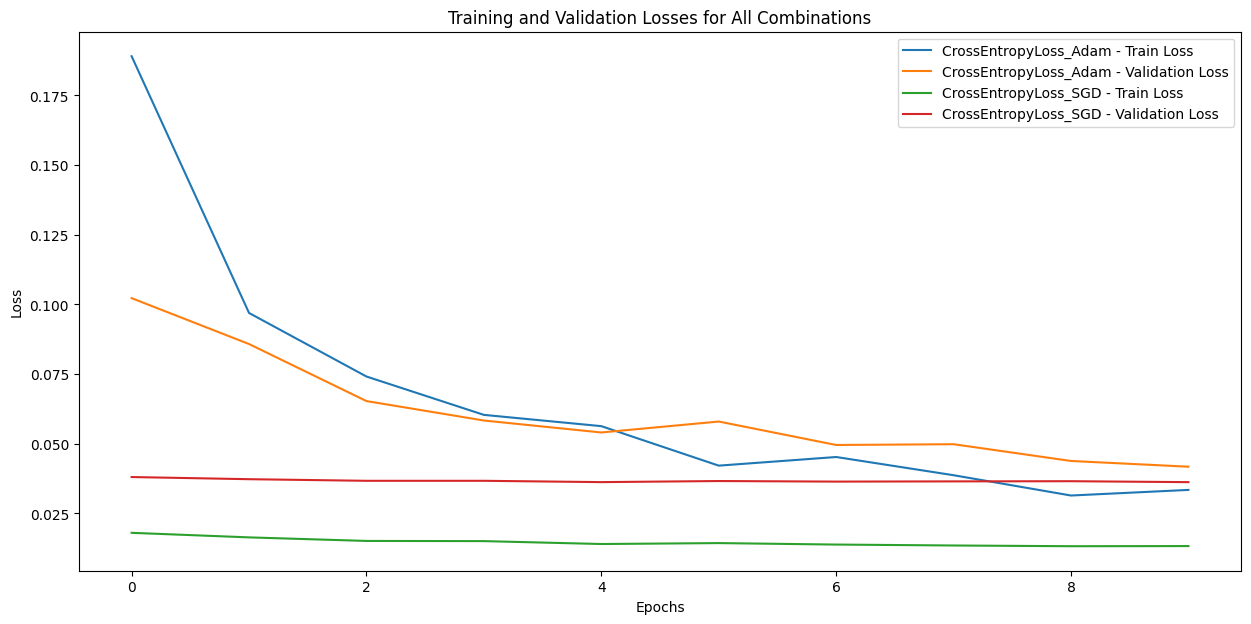

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# 각 조합에 대한 손실을 그래프에 추가
for combination_name, losses in results.items():
    plt.plot(losses['train_losses'], label=f'{combination_name} - Train Loss')
    plt.plot(losses['val_losses'], label=f'{combination_name} - Validation Loss')

# 그래프 제목 및 축 레이블 설정
plt.title('Training and Validation Losses for All Combinations')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 범례 표시
plt.legend()

# 그래프 표시
plt.show()

In [17]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Ensure the model is in evaluation mode
model.eval()

# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# No gradient calculation needed during evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader here
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f} %')

Accuracy on the test set: 99.15 %
